In [2]:
# Install dependencies
import sys

!{sys.executable} -m pip install smdebug
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install bokeh
!{sys.executable} -m pip install imageio

You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 15.2MB 18.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/af/bf/8d189a5c43460f6b5c8eb81ead8732e94b9f73ef8d9abba9e8f5a61a6531/opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 573kB 15.0MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/

# Analyze US census data for population segmentation using Amazon SageMaker

### https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/ ###


## Introduction

In the United States, within the current electoral systems, people are looking for more information about the voting process. This example notebook explores how we can apply machine learning (ML) to better integrate science into the task of understanding the electorate.

Typically, for machine learning applications, clear use cases are derived from labelled data. For example, based on the attributes of a device, such as its age or model number, we can predict its likelihood of failure. We call this *supervised learning* because there is supervision or guidance towards predicting specific outcomes.

However, in the real world, there are often large data sets where there is no particular outcome to predict, where clean labels are hard to define. It can be difficult to pinpoint exactly what the right outcome is to predict. This type of use case is often exploratory. It seeks to understand the makeup of a dataset and what natural patterns exist. This type of use case is known as `unsupervised learning`. One example of this is trying to group similar individuals together based on a set of attributes.

The use case this blog post explores is population segmentation. We have taken publicly available, anonymized data from the US census on demographics by different US counties: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml. (Note that this product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.) The outcome of this analysis are natural groupings of similar counties in a transformed feature space. The cluster that a county belongs to can be leveraged to plan an election campaign, for example, to understand how to reach a group of similar counties by highlighting messages that resonate with that group. More generally, this technique can be applied by businesses in customer or user segmentation to create targeted marketing campaigns. This type of analysis has the ability to uncover similarities that may not be obvious at face value- such as counties CA-Fresno and AZ- Yuma County being grouped together. While intuitively they differ in commonly-examined attributes such as population size and racial makeup, they are more similar than different when viewed along axes such as the mix of employment type.

You can follow along in this sample notebook where you can run the code and interact with the data while reading through the blog post (link is shown above).

There are two goals for this exercise:

1) Walk through a data science workflow using Amazon SageMaker for `unsupervised learning` using `PCA` and `KMeans` modelling techniques.

2) Demonstrate how users can access the underlying models that are built within Amazon SageMaker to extract useful model attributes. Often, it can be difficult to draw conclusions from unsupervised learning, so being able to access the models for `PCA` and `KMeans` becomes even more important beyond simply generating predictions using the model.

The data science workflow has 4 main steps:

1. [Loading the data from Amazon S3](#Step-1:-Loading-the-data-from-Amazon-S3)
2. [Exploratory data analysis (EDA) - Data cleaning and exploration](#Step-2:-Exploratory-data-analysis-EDA---Data-cleaning-and-exploration)
   1. [Cleaning the data](#a.-Cleaning-the-data)
   2. [Visualizing the data](#b.-Visualizing-the-data)
   3. [Feature engineering](#c.-Feature-engineering)
3. [Data modelling](#Step-3:-Data-modelling)
   1. [Dimensionality reduction](#a.-Dimensionality-reduction)
   2. [Accessing the PCA model attributes](#b.-Accessing-the-PCA-model-attributes)
   3. [Deploying the PCA model](#c.-Deploying-the-PCA-model)
   4. [Population segmentation using unsupervised clustering](#d.-Population-segmentation-using-unsupervised-clustering)
4. [Drawing conclusions from our modelling](#Step-4:-Drawing-conclusions-from-our-modelling)
    1. [Accessing the KMeans model attributes](#a.-Accessing-the-KMeans-model-attributes)

## Step 1: Loading the data from Amazon S3

You need to load the dataset from an Amazon S3 bucket into the Amazon SageMaker notebook.

First, we will import the relevant libraries into our Amazon SageMaker notebook.

In [2]:
# Allows the printing of multiple sets of output from the code in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
pip install mxnet

  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use("ggplot")
import pickle, gzip, urllib, json
import csv

Amazon SageMaker integrates seamlessly with Amazon S3. During the first step in creating the notebook, we specified a `AmazonSageMakerFullAccess` role for the notebook. That gives this notebook permission to access any Amazon S3 bucket in this AWS account with "sagemaker" in its name.

The get_execution_role function retrieves the IAM role you created at the time you created your notebook instance.

In [2]:
from sagemaker import get_execution_role

role = get_execution_role()

We can see our role is an AmazonSageMaker-ExecutionRole.

In [3]:
role

'arn:aws:iam::830665216626:role/service-role/AmazonSageMaker-ExecutionRole-20220222T152112'

#### Loading the dataset
I have previously downloaded and stored the data in a public S3 bucket that you can access. You can use the Python SDK to interact with AWS using a Boto3 client.

First, start the client.

In [19]:
s3_client = boto3.client("s3")
data_bucket_name = "aws-ml-blog-sagemaker-census-segmentation"

You’ll get a list of objects that are contained within the bucket.  You can see there is one file in the bucket, 'Census_Data_for_SageMaker.csv'.

In [5]:
obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['Census_Data_for_SageMaker.csv']


In [10]:
print(obj_list)

{'ResponseMetadata': {'RequestId': 'P939Z3T84639WVSN', 'HostId': '+LWZDQY6e1or53APAH0WYZEQvCSlyirTYLD3Z99ksH6dvn5+O/sJhVjFxy8sHXng84ZgIgYQg2M=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '+LWZDQY6e1or53APAH0WYZEQvCSlyirTYLD3Z99ksH6dvn5+O/sJhVjFxy8sHXng84ZgIgYQg2M=', 'x-amz-request-id': 'P939Z3T84639WVSN', 'date': 'Tue, 02 Aug 2022 00:13:30 GMT', 'x-amz-bucket-region': 'us-east-1', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Marker': '', 'Contents': [{'Key': 'Census_Data_for_SageMaker.csv', 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzlocal()), 'ETag': '"066d37f43f7762f1eb409b1660fe9763"', 'Size': 613237, 'StorageClass': 'STANDARD'}], 'Name': 'aws-ml-blog-sagemaker-census-segmentation', 'Prefix': '', 'MaxKeys': 1000, 'EncodingType': 'url'}


In [24]:
# there is one file --> one key
file_name=file[0]

print(file_name)

Census_Data_for_SageMaker.csv


In [7]:
file_data = file[0]

In [9]:
data_bucket_name

'aws-ml-blog-sagemaker-census-segmentation'

Grab the data from the CSV file in the bucket.

In [11]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
counties = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [26]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=data_bucket_name, Key=file_name)

# what info does the object contain? - same as reponse given below
display(data_object)

{'ResponseMetadata': {'RequestId': 'GB0ZGB91RKE7Z9BE',
  'HostId': 'BlCv7zs9oGmwXRoR4dwltNOcQYHZkxR4LUV/OGK1+EdqPx6kbOQDqGmghJRlQaEmtOyP4FQJgdk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'BlCv7zs9oGmwXRoR4dwltNOcQYHZkxR4LUV/OGK1+EdqPx6kbOQDqGmghJRlQaEmtOyP4FQJgdk=',
   'x-amz-request-id': 'GB0ZGB91RKE7Z9BE',
   'date': 'Tue, 02 Aug 2022 03:02:35 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'server': 'AmazonS3',
   'content-length': '613237'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f3dfcc18150>}

In [27]:
# information is in the "Body" of the object
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


In [28]:
# Alternative code just of understanding 
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [29]:
counties_df.isna().sum()[counties_df.isna().sum()>0]

Income          1
IncomeErr       1
ChildPoverty    1
dtype: int64

In [30]:
# drop any incomplete rows of data, and create a new df
clean_counties_df = counties_df.dropna(axis=0)

In [31]:
clean_counties_df.shape

(3218, 37)

In [32]:
clean_counties_df.index=clean_counties_df['State'] + "-" + clean_counties_df['County']

In [33]:
clean_counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [34]:
# drop the old State and County columns, and the CensusId column
# clean df should be modified or created anew
clean_counties_df = clean_counties_df.drop(['CensusId','State','County'], axis=1)


In [35]:
clean_counties_df.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [39]:
# features
features_list = clean_counties_df.columns.values
print('Features:\n', features_list)

Features:
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


In [40]:
pd.__version__

'1.3.5'

In [42]:
!aws s3 mb s3://aws-ml-blog-sagemaker-census-segmentation-830665216626

make_bucket: aws-ml-blog-sagemaker-census-segmentation-830665216626


In [56]:
# Copy pandas dataframe from here to s3
from io import StringIO # python3; python2: BytesIO 
import boto3
bucket = "aws-ml-blog-sagemaker-census-segmentation-830665216626"
csv_buffer = StringIO()
counties_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'counties.df.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'AZ9DD9YMVCNJADC1',
  'HostId': 'wUe8CBpacmALTUIRvkM82XPW0HYbUiyTJki1XmARG1zBHvYnuidnpC+ijrgPjX3NyF7X6qLVTP8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wUe8CBpacmALTUIRvkM82XPW0HYbUiyTJki1XmARG1zBHvYnuidnpC+ijrgPjX3NyF7X6qLVTP8=',
   'x-amz-request-id': 'AZ9DD9YMVCNJADC1',
   'date': 'Tue, 02 Aug 2022 03:32:13 GMT',
   'etag': '"ac32289e57603166c495c8a49355553d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"ac32289e57603166c495c8a49355553d"'}

In [12]:
response

{'ResponseMetadata': {'RequestId': 'N6FSHS69A9EM4JYS',
  'HostId': 'eB/pkF1l56A9pe/+1rCMozOle+e20e+gr6EdPeuxxeLpN7Th3hJXq1aLVSecEn52vzFWcaM16jM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'eB/pkF1l56A9pe/+1rCMozOle+e20e+gr6EdPeuxxeLpN7Th3hJXq1aLVSecEn52vzFWcaM16jM=',
   'x-amz-request-id': 'N6FSHS69A9EM4JYS',
   'date': 'Tue, 02 Aug 2022 00:27:16 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'server': 'AmazonS3',
   'content-length': '613237'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f3dfbee7ad0>}

This is what the first 5 rows of our data looks like:

In [22]:
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [14]:
type(counties)
counties.info
counties.shape

(3220, 37)

## Step 2: Exploratory data analysis *EDA* - Data cleaning and exploration
### a. Cleaning the data
We can do simple data cleaning and processing right in our notebook instance, using `the compute` instance of the notebook to execute these computations.

How much data are we working with?

There are 3220 rows with 37 columns

In [15]:
counties.shape

(3220, 37)

Let's just drop any incomplete data to make our analysis easier. We can see that we lost 2 rows of incomplete data, we now have 3218 rows in our data.

In [16]:
counties.dropna(inplace=True)
counties.shape

(3218, 37)

Let's combine some descriptive reference columns such as state and county and leave the numerical feature columns.

We can now set the 'state-county' as the index and the rest of the numerical features become the attributes of each unique county.

In [17]:
counties.index = counties["State"] + "-" + counties["County"]
counties.head()
drop = ["CensusId", "State", "County"]
counties.drop(drop, axis=1, inplace=True)
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### b. Visualizing the data
Now we have a dataset with a mix of numerical and categorical columns. We can visualize the data for some of our numerical columns and see what the distribution looks like.

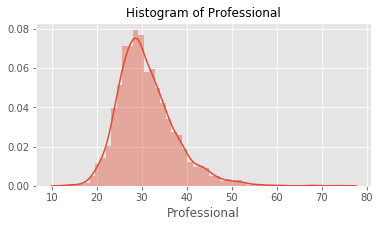

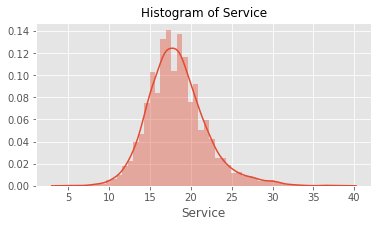

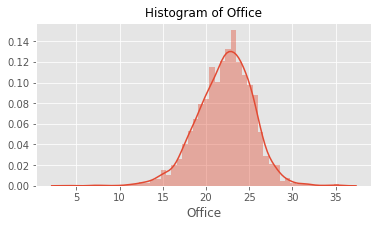

In [18]:
import seaborn as sns

for a in ["Professional", "Service", "Office"]:
    ax = plt.subplots(figsize=(6, 3))
    ax = sns.distplot(counties[a])
    title = "Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

For example, from the figures above you can observe the distribution of counties that have a percentage of workers in Professional, Service, or Office occupations. Viewing the histograms can visually indicate characteristics of these features such as the mean or skew. The distribution of Professional workers for example reveals that the typical county has around 25-30% Professional workers, with a right skew, long tail and a Professional worker % topping out at almost 80% in some counties.

### c. Feature engineering

**Data Scaling**- We need to standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. We can use `minmaxscaler` to transform the numerical columns so that they also fall between 0 and 1.

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
counties_scaled = pd.DataFrame(scaler.fit_transform(counties))
counties_scaled.columns = counties.columns
counties_scaled.index = counties.index
counties_scaled.head(5)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


We can see that all of our numerical columns now have a min of 0 and a max of 1.

In [21]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 3: Data modelling
### a. Dimensionality reduction

We will be using principal component analysis (PCA) to reduce the dimensionality of our data. This method decomposes the data matrix into features that are orthogonal with each other. The resultant orthogonal features are linear combinations of the original feature set. You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in Amazon SageMaker algorithm for PCA.

We first import and call an instance of the PCA SageMaker model. Then we specify different parameters of the model. These can be resource configuration parameters, such as how many instances to use during training, or what type of instances to use. Or they can be model computation hyperparameters, such as how many components to use when performing PCA. Documentation on the PCA model can be found here: http://sagemaker.readthedocs.io/en/latest/pca.html

You will use the tools provided by the Amazon SageMaker Python SDK to upload the data to a default bucket. 

In [22]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

In [23]:
print(bucket)

sagemaker-us-east-1-830665216626


In [24]:
from sagemaker import PCA

num_components = 33

pca_SM = PCA(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/counties/",
    num_components=num_components,
)

Next, we prepare data for Amazon SageMaker by extracting the `numpy array` from the `DataFrame` and explicitly casting to `float32`

In [25]:
train_data = counties_scaled.values.astype("float32")

In [26]:
output_path="s3://" + bucket + "/counties/"
print(output_path)

s3://sagemaker-us-east-1-830665216626/counties/


The *record_set* function in the Amazon SageMaker `PCA` model converts a `numpy array` into a record set format that is the required format for the input data to be trained. This is a requirement for all Amazon SageMaker built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, for larger data sets compared with other implementations of the same models, such as the `sklearn` implementation.

We call the fit function on our PCA model, passing in our training data, and this spins up a training instance or cluster to perform the training job.

In [27]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-07-20 00:31:43 Starting - Starting the training job...
2022-07-20 00:32:09 Starting - Preparing the instances for trainingProfilerReport-1658277103: InProgress
.........
2022-07-20 00:33:28 Downloading - Downloading input data......
2022-07-20 00:34:36 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/20/2022 00:34:42 INFO 140403044505408] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[07/20/2022 00:34:42 INFO 140403044505408] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '34', 'mini_batch_size': '500', 'num_components': '33'}
[07/20/2

### b. Accessing the PCA model attributes

After the model is created, we can also access the underlying model parameters.

Now that the training job is complete, you can find the job under **Jobs** in the **Training** subsection in the Amazon SageMaker console.

Model artifacts are stored in Amazon S3 after they have been trained. This is the same model artifact that is used to deploy a trained model using Amazon SageMaker. Since many of the Amazon SageMaker algorithms use MXNet for computational speed, the model artifact is stored as an ND array. For an output path that was specified during the training call, the model resides in `<training_job_name>/output/model.tar.gz` file, which is a TAR archive file compressed with GNU zip (`gzip`) compression.

In [28]:
job_name = pca_SM.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

- Amazon SageMaker models are stored as model.tar.gz in the S3 bucket specified in OutputDataConfig S3OutputPath parameter of the create_training_job call. You can specify most of these model artifacts when creating a hosting model. You can also open and review them in your notebook instance. When model.tar.gz is untarred, it contains model_algo-1, which is a serialized Apache MXNet object. For example, you use the following to load the k-means model into memory and view it:

- import mxnet as mx

- print(mx.ndarray.load('model_algo-1'))

In [29]:
cmd = 'date'
os.system(cmd)

0

In [30]:
print(model_key)
print(boto3.resource("s3").Bucket(bucket))

counties/pca-2022-07-20-00-31-43-782/output/model.tar.gz
s3.Bucket(name='sagemaker-us-east-1-830665216626')


After the model is decompressed, we can load the ND array using MXNet.

In [31]:
import mxnet as mx

pca_model_params = mx.ndarray.load("model_algo-1")
# mxnet is used to access the ND array which is an output from PCA

In [32]:
print(mx.ndarray.load('model_algo-1'))

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


In [35]:
model_algo_1 = (mx.ndarray.load('model_algo-1'))
type(model_algo_1)

dict

In [70]:
model_algo_1_df = pd.DataFrame.from_dict([model_algo_1])
print(model_algo_1_df)

                                                   s  \
0  [[[\n[0.01789636]\n<NDArray 1 @cpu(0)>]], [[\n...   

                                                   v  \
0  [[[\n[0.0024687]\n<NDArray 1 @cpu(0)>], [\n[0....   

                                                mean  
0  [[[\n[0.00988273]\n<NDArray 1 @cpu(0)>], [\n[0...  


In [37]:
type(pca_model_params)
print(pca_model_params)

dict

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


**Three groups of model parameters are contained within the PCA model.**

`mean` is optional and is only available if the “subtract_mean” hyperparameter is true when calling the training step from the original PCA SageMaker function.

`v` contains the principal components (same as ‘components_’ in the `sklearn PCA` model).

`s` the singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

`explained-variance-ratio` ~= square(s) / sum(square(s))

To calculate the exact `explained-variance-ratio` vector if needed, it simply requires saving the sum of squares of the original data (call that N) and computing explained-variance-ratio = square(s) / N.

In [38]:
s = pd.DataFrame(pca_model_params["s"].asnumpy())
v = pd.DataFrame(pca_model_params["v"].asnumpy())

We can now calculate the variance explained by the largest n components that we want to keep. For this example, let's take the top 5 components.

We can see that the largest 5 components explain ~72% of the total variance in our dataset:

In [39]:
s.iloc[28:, :].apply(lambda x: x * x).sum() / s.apply(lambda x: x * x).sum()

0    0.717983
dtype: float32

After we have decided to keep the top 5 components, we can take only the 5 largest components from our original s and v matrix.

In [40]:
s_5 = s.iloc[28:, :]
v_5 = v.iloc[:, 28:]
v_5.columns = [0, 1, 2, 3, 4]

We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. For example, the following code shows the first component. We can see that this component describes an attribute of a county that has high poverty and unemployment, low income and income per capita, and high Hispanic/Black population and low White population.

Note that this is v_5[4] or last component of the list of components in v_5, but is actually the largest component because the components are ordered from smallest to largest. So v_5[0] would be the smallest component. Similarly, change the value of component_num to cycle through the makeup of each component.

Text(0.5, 1.0, 'PCA Component Makeup: #1')

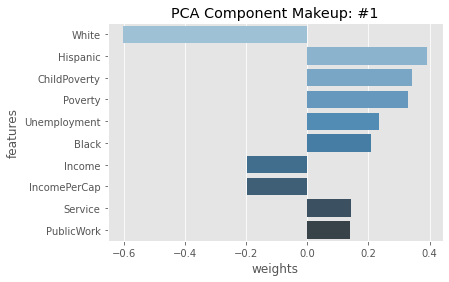

In [41]:
component_num = 1

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, counties_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

Text(0.5, 1.0, 'PCA Component Makeup: #2')

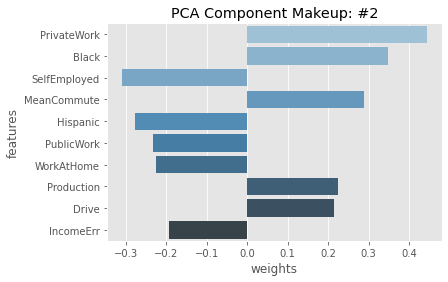

In [42]:
component_num = 2

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, counties_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

Text(0.5, 1.0, 'PCA Component Makeup: #3')

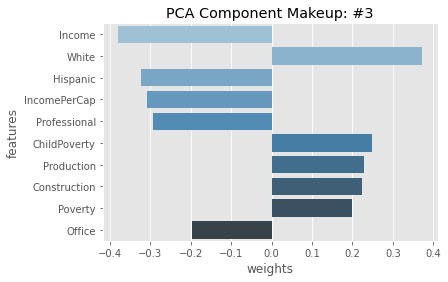

In [43]:
component_num = 3

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, counties_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

Text(0.5, 1.0, 'PCA Component Makeup: #4')

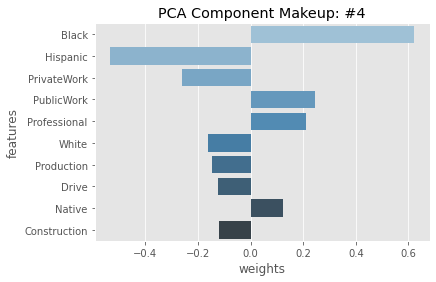

In [44]:
component_num = 4

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, counties_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

Similarly, you can go through and examine the makeup of each PCA components and try to understand what the key positive and negative attributes are for each component. The following code names the components, but feel free to change them as you gain insight into the unique makeup of each component.

Text(0.5, 1.0, 'PCA Component Makeup: #5')

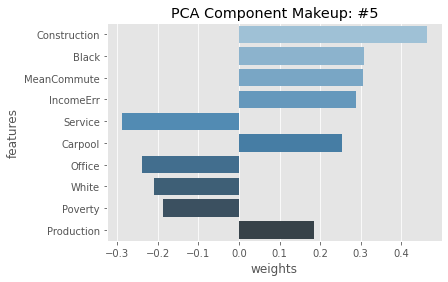

In [45]:
component_num = 5

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, counties_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [46]:
PCA_list = ["comp_1", "comp_2", "comp_3", "comp_4", "comp_5"]

# PCA_list=["Poverty/Unemployment", "Self Employment/Public Workers", "High Income/Professional & Office Workers", \
#         "Black/Native Am Populations & Public/Professional Workers", "Construction & Commuters"]
print(PCA_list)

['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5']


### c. Deploying the PCA model

We can now deploy this model endpoint and use it to make predictions. This model is now live and hosted on an instance_type that we specify.

In [47]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------!CPU times: user 236 ms, sys: 16.5 ms, total: 253 ms
Wall time: 5min 32s


We can also pass our original dataset to the model so that we can transform the data using the model we created. Then we can take the largest 5 components and this will reduce the dimensionality of our data from 34 to 5.

In [48]:
%%time
result = pca_predictor.predict(train_data)

CPU times: user 201 ms, sys: 4.02 ms, total: 205 ms
Wall time: 496 ms


In [49]:
type(result)
len(result)
print(result[:2])

list

3218

[label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 

In [50]:
counties_transformed = pd.DataFrame()
for a in result:
    b = a.label["projection"].float32_tensor.values
    counties_transformed = counties_transformed.append([list(b)])
counties_transformed.index = counties_scaled.index
counties_transformed = counties_transformed.iloc[:, 28:]
counties_transformed.columns = PCA_list

Now we have created a dataset where each county is described by the 5 principal components that we analyzed earlier. Each of these 5 components is a linear combination of the original feature space. We can interpret each of these 5 components by analyzing the makeup of the component shown previously.

In [51]:
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030


### d. Population segmentation using unsupervised clustering

Now, we’ll use the `KMeans` algorithm to segment the population of counties by the 5 `PCA` attributes we have created. `KMeans` is a clustering algorithm that identifies clusters of similar counties based on their attributes. Since we have ~3000 counties and 34 attributes in our original dataset, the large feature space may have made it difficult to cluster the counties effectively. Instead, we have reduced the feature space to 5 PCA components, and we’ll cluster on this transformed dataset.

In [52]:
train_data = counties_transformed.values.astype("float32")

First, we call and define the hyperparameters of our `KMeans` model as we have done with our `PCA` model. The `KMeans` algorithm allows the user to specify how many clusters to identify. In this instance, let's try to find the top 7 clusters from our dataset.

In [53]:
from sagemaker import KMeans

num_clusters = 7
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/counties/",
    k=num_clusters,
)

Then we train the model on our training data.

In [54]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-07-20 00:47:27 Starting - Starting the training job...ProfilerReport-1658278047: InProgress
...
2022-07-20 00:48:27 Starting - Preparing the instances for training......
2022-07-20 00:49:27 Downloading - Downloading input data...
2022-07-20 00:49:47 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/20/2022 00:50:32 INFO 140293154420544] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', '_num_gpus': 'auto', '_num_k

Now we deploy the model, and we can pass in the original training set to get the labels for each entry. This will give us which cluster each county belongs to.

In [55]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------------!CPU times: user 290 ms, sys: 26.6 ms, total: 316 ms
Wall time: 8min 2s


In [56]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 228 ms, sys: 5.54 ms, total: 234 ms
Wall time: 590 ms


We can see the breakdown of cluster counts and the distribution of clusters.

In [57]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [58]:
pd.DataFrame(cluster_labels)[0].value_counts()

0.0    950
5.0    816
2.0    440
1.0    363
4.0    318
6.0    234
3.0     97
Name: 0, dtype: int64

/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Cluster Counts')

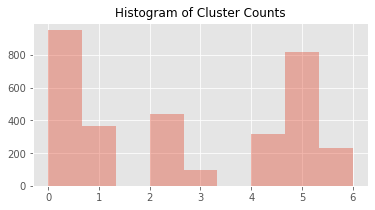

In [59]:
ax = plt.subplots(figsize=(6, 3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

However, to improve `explainability`, we need to access the underlying model to get the cluster centers. These centers will help describe which features characterize each cluster.

## Step 4: Drawing conclusions from our modelling

Explaining the result of the modelling is an important step in making use of our analysis. By combining `PCA` and `KMeans`, and the information contained in the model attributes within an Amazon SageMaker trained model, we can form concrete conclusions based on the data.

### a. Accessing the KMeans model attributes

First, we will go into the bucket where the `KMeans` model is stored and extract it.

In [60]:
job_name = kmeans.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

In [61]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")

**There is 1 set of model parameters that is contained within the KMeans model.**

**Cluster Centroid Locations**: The location of the centers of each cluster identified by the `KMeans` algorithm. The cluster location is given in our `PCA` transformed space with 5 components, since we passed the transformed `PCA` data into the model.

In [62]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = counties_transformed.columns

In [63]:
cluster_centroids

,comp_1,comp_2,comp_3,comp_4,comp_5
0,-0.010791,-0.073297,0.139028,0.087710,-0.029990
1,0.100566,0.286400,0.069619,0.250331,0.381043
2,0.009703,0.078190,0.086029,-0.333044,-0.230434
3,-0.090193,-0.419409,-0.190891,-0.236237,1.247325
4,0.022120,0.085916,-0.392767,0.059366,-0.035452
5,-0.045603,-0.048927,-0.057999,0.057209,-0.237283
6,0.047358,-0.023432,-0.011858,-0.310702,0.381314


We can plot a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA plus clustering techniques together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the `PCA` components that we interpreted previously.

For example, we can see that cluster 1 has the highest value in the "Construction & Commuters" attribute while it has the lowest value in the "Self Employment/Public Workers" attribute compared with other clusters. Similarly, cluster 4 has high values in "Construction & Commuters," "High Income/Professional & Office Workers," and "Self Employment/Public Workers."

<Figure size 1152x432 with 0 Axes>

Text(0.5, 33.0, 'Cluster')

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'comp_1'),
  Text(0, 1.5, 'comp_2'),
  Text(0, 2.5, 'comp_3'),
  Text(0, 3.5, 'comp_4'),
  Text(0, 4.5, 'comp_5')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, '0'),
  Text(1.5, 0, '1'),
  Text(2.5, 0, '2'),
  Text(3.5, 0, '3'),
  Text(4.5, 0, '4'),
  Text(5.5, 0, '5'),
  Text(6.5, 0, '6')])

Text(0.5, 1.0, 'Attribute Value by Centroid')

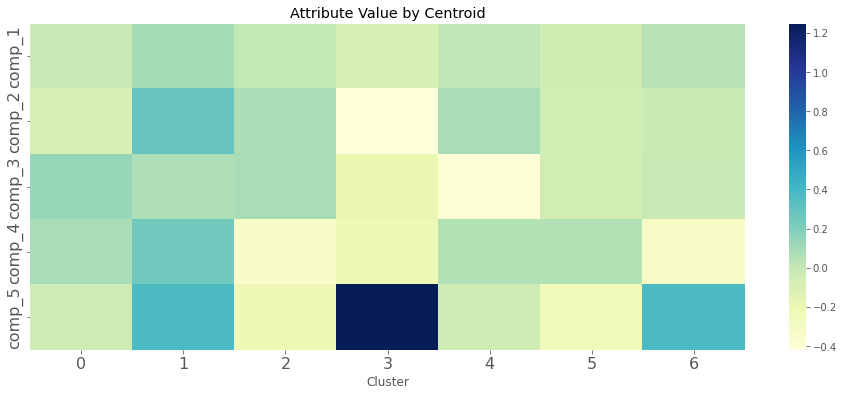

In [64]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap="YlGnBu")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()

We can also map the cluster labels back to each individual county and examine which counties were naturally grouped together.

In [65]:
counties_transformed["labels"] = list(map(int, cluster_labels))
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274,5
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,5
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202,1
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224,0
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030,0


Now, we can examine one of the clusters in more detail, like cluster 1 for example. A cursory glance at the location of the centroid tells us that it has the highest value for the "Construction & Commuters" attribute. We can now see which counties fit that description.

In [66]:
cluster = counties_transformed[counties_transformed["labels"] == 1]
cluster.head(5)

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202,1
Alabama-Bullock,0.560001,0.420578,0.137942,0.379008,0.654808,1
Alabama-Butler,0.119178,0.234928,0.118341,0.351712,0.348724,1
Alabama-Chambers,0.169158,0.137235,0.051224,0.452345,0.240976,1
Alabama-Choctaw,0.281012,0.208039,0.140128,0.346074,0.312955,1


## Conclusion

You have just walked through a data science workflow for unsupervised learning, specifically clustering a dataset using KMeans after reducing the dimensionality using PCA. By accessing the underlying models created within Amazon SageMaker, we were able to improve the `explainability` of our modelling and draw actionable conclusions. Using these techniques, we have been able to better understand the essential characteristics of different counties in the US and segment the electorate into groupings accordingly.

###### Because endpoints are persistent, let’s delete our endpoints now that we’re done to avoid any excess charges on our AWS bill.

In [67]:
pca_predictor.delete_endpoint()

In [68]:
kmeans_predictor.delete_endpoint()